In [1]:
import torch
import torch.nn as nn

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Dataset

In [3]:
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collate_fn, plot_mri_slice, plot_all_slices, plot_all_slices_from_array

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [4]:
ds = Dataset()

In [5]:
masks = ds.load_cmb_masks()
cases = ds.load_raw_mri()

In [6]:
transform = NiftiToTensorTransform(target_shape=(100, 100))

In [7]:
dataset = VALDODataset(
    cases=cases,
    masks=masks,
    transform=transform,
    normalization=z_score_normalization
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [8]:
dloader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=1,
    collate_fn=collate_fn
)

In [9]:
sample = next(enumerate(dloader))

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


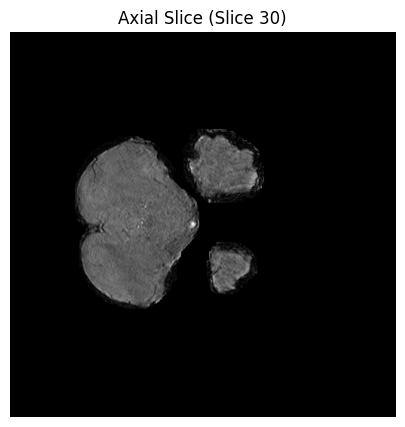

In [10]:
plot_mri_slice(sample[1][2][0])

# Model

In [11]:
from project.model import RPN

In [12]:
rpn = RPN(10000, 4, 8, 200).to(device)

C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
x = torch.randn(5, 1, 10000)
y = torch.randn(1, 1, 10000)

In [14]:
x.shape

torch.Size([5, 1, 10000])

In [15]:
out = rpn(x[0])
out

C:\Program Files\Python310\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


tensor([[-0.0128, -0.1152, -0.1993, -0.2813]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [16]:
sample[1][0][0].shape

torch.Size([1, 1, 100, 100])

In [28]:
tt = sample[1][0][0].flatten().unsqueeze(0).unsqueeze(0)

In [34]:
tt = tt.to(device)

In [64]:
rpn(tt.float())

tensor([[[ 0.6047, -0.1608, -0.9992, -1.7525]]], device='cuda:0',
       grad_fn=<ViewBackward0>)

# Key Takeaways

assigning a `d_model` of $512^2%$ or $256^2$ to the RPN is too demanding memory-wise.

There needs to be a way to reduce the demand of the RPN Transformer in the memory or simply reduce the size of the input.

Reducing the size of the input to a maximum of `d_model` $= 10000$ would mean that the size of the MRI images would have to be reduced to $100 \times 100$ if they will be fed into the RPN directly.

another possible solution could be to use an autoencoder to extract key features features from the brain and feed those extracted features that could be as big as $10000$ features to the RPN.

HOWEVER, microbleeds are not "key features" that an autoencoder might detect. **note** that what we are trying to find are essentially outliers in a dataset so using an autoencoder to extract features may not be a good idea (not yet tested though so there's still a chance).

### Next plan: Train the model with a reduced `d_model`